# Модуль 7. **Рекомендаційні системи**

In [460]:
# install surprise - write in terminal
# pip install scikit-surprise

In [461]:
import pandas as pd
import numpy as np
from surprise.model_selection import train_test_split, cross_validate, GridSearchCV
import matplotlib.pyplot as plt
from surprise import accuracy, Dataset
from surprise import SVD, SVDpp, NMF
from scipy.io import loadmat

### Завдання

##### Візьміть датасет movielens і побудуйте модель матричної факторизації. У даній бібліотеці він має назву SVD. Підберіть найкращі параметри за допомогою крос-валідації, також поекспериментуйте з іншими алгоритмами розрахунків (SVD++, NMF) і оберіть той, який буде оптимальним.

##### Підказки як саме побудувати дану модель ви знайдете в документації до даної бібліотеки.

    Завантаження та аналіз даних

In [462]:
data = Dataset.load_builtin("ml-100k", prompt=False)

In [463]:
data_df = pd.DataFrame(data.raw_ratings, columns=["user_id", "item_id", "rating", "timestamp"])
data_df.head()

,user_id,item_id,rating,timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596


In [464]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    100000 non-null  object 
 1   item_id    100000 non-null  object 
 2   rating     100000 non-null  float64
 3   timestamp  100000 non-null  object 
dtypes: float64(1), object(3)
memory usage: 3.1+ MB


    Параметри

In [465]:
models = [SVD(), SVDpp(), NMF()]

measures = ["rmse", "mae"]

params_svd = {
    # "n_epochs": [20, 30, 50, 100],
    "n_epochs": [5, 10, 20],
    "lr_all": [0.002, 0.005, 0.01],
    "reg_all": [0.02, 0.1, 0.4],
}
params_nmf = {
    "n_epochs": [5, 10, 20],
    "lr_bu": [0.002, 0.005, 0.01],
    "reg_bu": [0.02, 0.1, 0.4],
}

    Функції

In [466]:
def grid_search_model(model, params=params_svd):
    grid_search = GridSearchCV(
        model, param_grid=params, measures=measures, n_jobs=-1, cv=5, joblib_verbose=0
    )

    grid_search.fit(data)

    # Виведення метрик
    for metric in measures:
        print('>>> ', metric.upper())
        print("Best", metric.upper(), "score for ", model,":", grid_search.best_score[metric])
        print(
            "Best parameters for", metric.upper(), ":", grid_search.best_params[metric])
    return grid_search, grid_search.best_score["rmse"]

In [467]:
# побудова точкової діаграми розподілу RMSE в залежності від комбінації параметрів params.

def plt_rmse_diagram(results_cv, params, model, best_score_rmse):
    plt.figure(figsize=(10, 6))

    n_epochs = params["n_epochs"]
    lr_all = params["lr_all"] if model != "nmf" else params["lr_bu"]
    reg_all = params["reg_all"] if model != "nmf" else params["reg_bu"]

    num_point = 0  # лічильник точок = i * len(n_epochs)*len(reg_all) + j * len(reg_all) + k

    for _, n_epoch in enumerate(n_epochs):
        for _, lr in enumerate(lr_all):
            for _, reg in enumerate(reg_all):

                if model != 'nmf':
                    params_str = f"n_epochs={'' if n_epoch>9 else ' '}{n_epoch},  lr_all={lr:.3f},  reg_all={reg:.2f}"
                else:
                    params_str = f"n_epochs={'' if n_epoch>9 else ' '}{n_epoch},  lr_bu={lr:.3f},  reg_bu={reg:.2f}"
                mean_rmse = results_cv["mean_test_rmse"][num_point]

                plt.scatter(
                    params_str,
                    mean_rmse,
                    color="red" if mean_rmse == best_score_rmse else "blue",
                    s=100,
                )
                num_point += 1

    # plt.xlabel("Parameters")
    plt.ylabel("RMSE")
    plt.title("Результати крос-валідації для моделі " + str(model.upper()))
    plt.xticks(rotation=90)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [468]:
# cross validation
cross_validate(SVD(), data, measures=measures, cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9300  0.9471  0.9358  0.9355  0.9283  0.9354  0.0066  
MAE (testset)     0.7309  0.7446  0.7392  0.7397  0.7327  0.7374  0.0050  
Fit time          0.71    0.70    0.72    0.70    0.73    0.71    0.01    
Test time         0.05    0.05    0.06    0.07    0.06    0.06    0.01    


{'test_rmse': array([0.92995371, 0.94714072, 0.93581368, 0.93552065, 0.92833179]),
 'test_mae': array([0.73092668, 0.74460281, 0.73919541, 0.73972645, 0.73265989]),
 'fit_time': (0.7101633548736572,
  0.6977477073669434,
  0.7171676158905029,
  0.6951525211334229,
  0.7331087589263916),
 'test_time': (0.04991722106933594,
  0.05399179458618164,
  0.0625145435333252,
  0.06874561309814453,
  0.06251311302185059)}

## SVD

In [469]:
print("Cross-validating SVD...")
svd_grid_search, svd_best_score_rmse = grid_search_model(SVD)

Cross-validating SVD...
>>>  RMSE
Best RMSE score for  <class 'surprise.prediction_algorithms.matrix_factorization.SVD'> : 0.9202227785097964
Best parameters for RMSE : {'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.1}
>>>  MAE
Best MAE score for  <class 'surprise.prediction_algorithms.matrix_factorization.SVD'> : 0.7282532669242795
Best parameters for MAE : {'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.1}


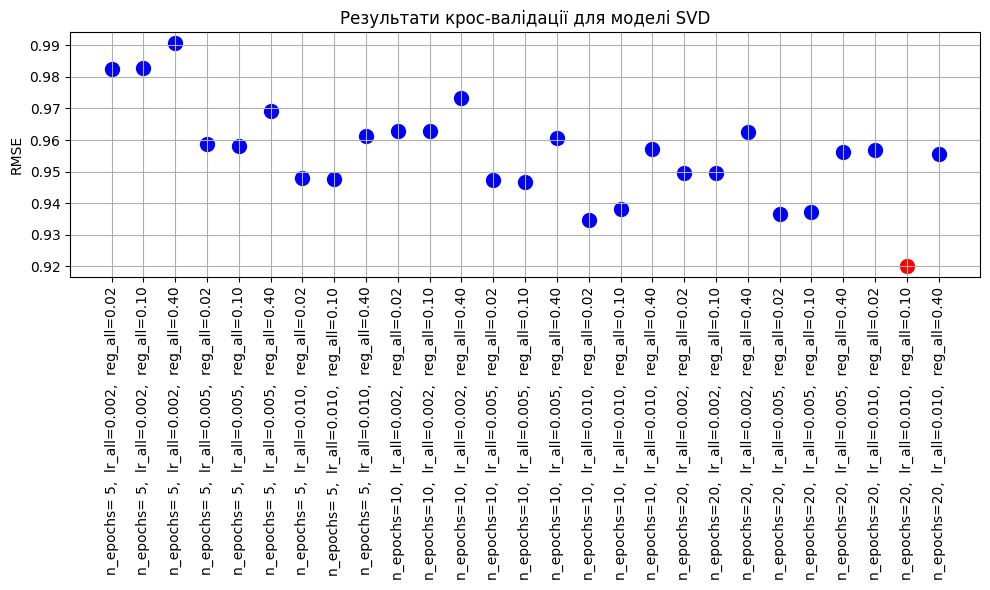

In [470]:
plt_rmse_diagram(svd_grid_search.cv_results, params_svd, 'svd', best_score_rmse=svd_best_score_rmse)

In [471]:
print(
    "Найкращі параметри для моделі SVD: \033[93m", svd_grid_search.best_params["rmse"]
)

Найкращі параметри для моделі SVD:  {'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.1}


## SVD++

In [472]:
print("Cross-validating SVD++...")
svdpp_grid_search, svdpp_best_score_rmse = grid_search_model(SVDpp)

Cross-validating SVD++...
>>>  RMSE
Best RMSE score for  <class 'surprise.prediction_algorithms.matrix_factorization.SVDpp'> : 0.9186528388517914
Best parameters for RMSE : {'n_epochs': 10, 'lr_all': 0.01, 'reg_all': 0.02}
>>>  MAE
Best MAE score for  <class 'surprise.prediction_algorithms.matrix_factorization.SVDpp'> : 0.7233375222841324
Best parameters for MAE : {'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.02}


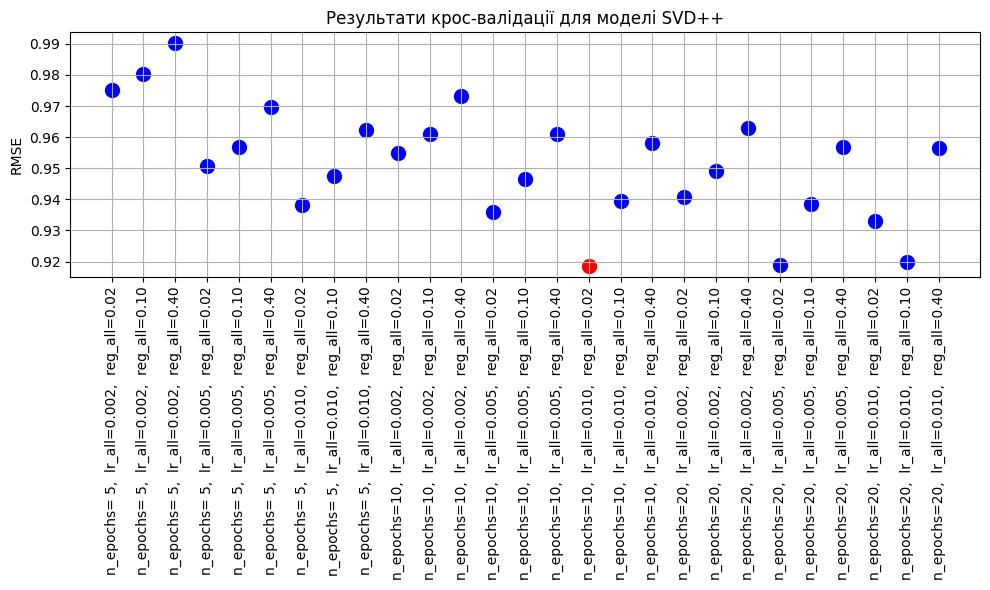

In [473]:
plt_rmse_diagram(svdpp_grid_search.cv_results, params_svd, "svd++", best_score_rmse=svdpp_best_score_rmse)

## NMF

In [474]:
print("Cross-validating NMF...")
nmf_grid_search, nmf_best_score_rmse = grid_search_model(NMF, params=params_nmf)

Cross-validating NMF...
>>>  RMSE
Best RMSE score for  <class 'surprise.prediction_algorithms.matrix_factorization.NMF'> : 0.9756866659484906
Best parameters for RMSE : {'n_epochs': 20, 'lr_bu': 0.002, 'reg_bu': 0.4}
>>>  MAE
Best MAE score for  <class 'surprise.prediction_algorithms.matrix_factorization.NMF'> : 0.7598070834369887
Best parameters for MAE : {'n_epochs': 20, 'lr_bu': 0.01, 'reg_bu': 0.4}


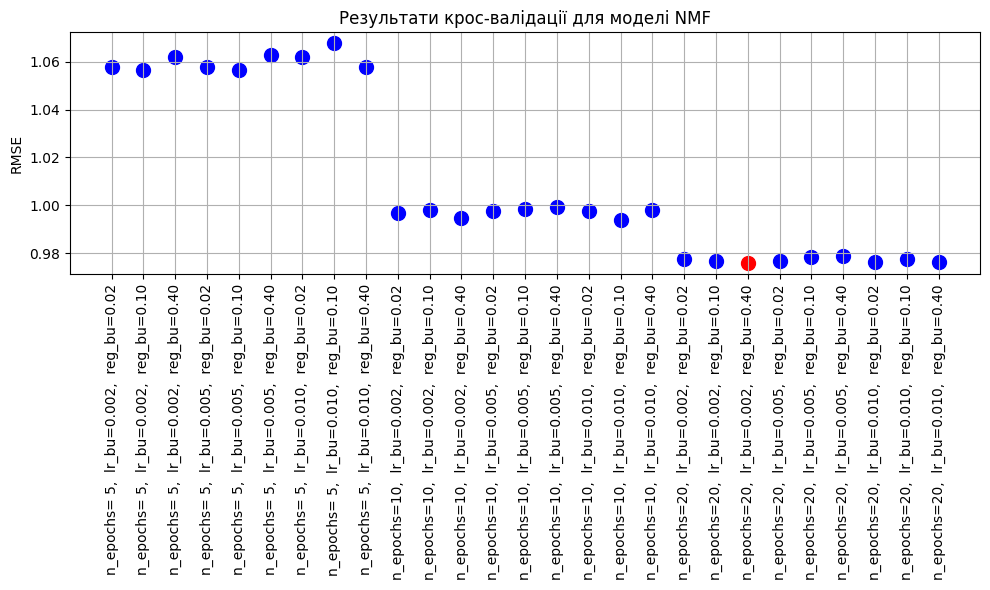

In [475]:
plt_rmse_diagram(
    nmf_grid_search.cv_results, params_nmf, "nmf", best_score_rmse=nmf_best_score_rmse
)

## Аналіз результатів для SVD, SVD++, NMF

In [476]:
results = {
    "Method": ["SVD", "SVD++", "NMF"],
    "RMSE": [
        svd_grid_search.best_score["rmse"],
        svdpp_grid_search.best_score["rmse"],
        nmf_grid_search.best_score["rmse"],
    ],
    "MAE": [
        svd_grid_search.best_score["mae"],
        svdpp_grid_search.best_score["mae"],
        nmf_grid_search.best_score["mae"],
    ],
}

df_results = pd.DataFrame(results)

print(df_results)

  Method      RMSE       MAE
0    SVD  0.920223  0.728253
1  SVD++  0.918653  0.723338
2    NMF  0.975687  0.759807


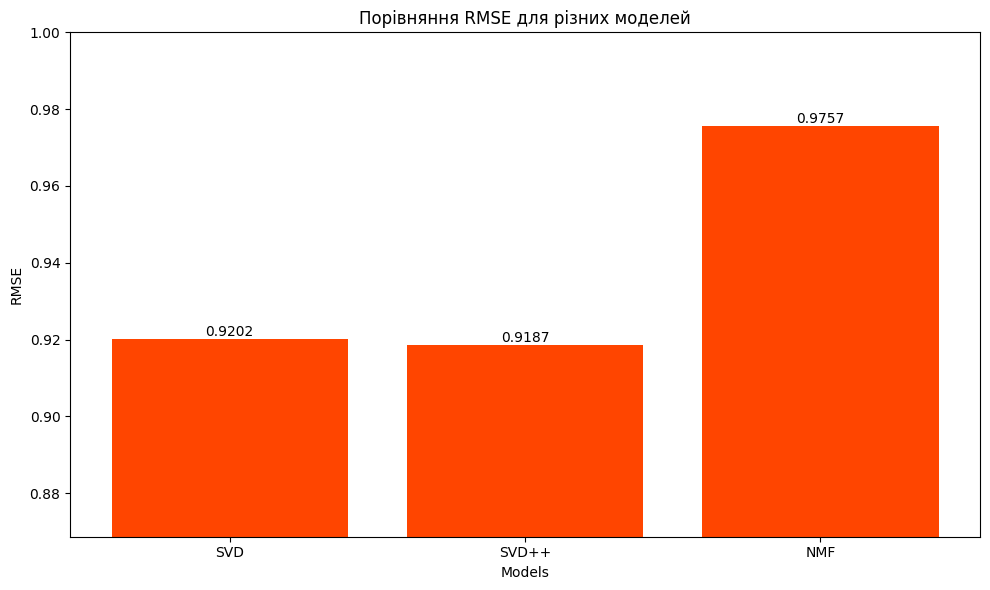

In [477]:
plt.figure(figsize=(10, 6))
plt.title("Порівняння RMSE для різних моделей")
plt.ylabel("RMSE")
plt.xlabel("Models")
plt.ylim(min(df_results["RMSE"]) - 0.05, 1)
plt.xticks(rotation=0)
bars = plt.bar(df_results["Method"], df_results["RMSE"], color="orangered")
plt.tight_layout()

for bar in bars:
    val = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        val,
        round(val, 4),
        va="bottom",
        ha="center",
    )

plt.show()

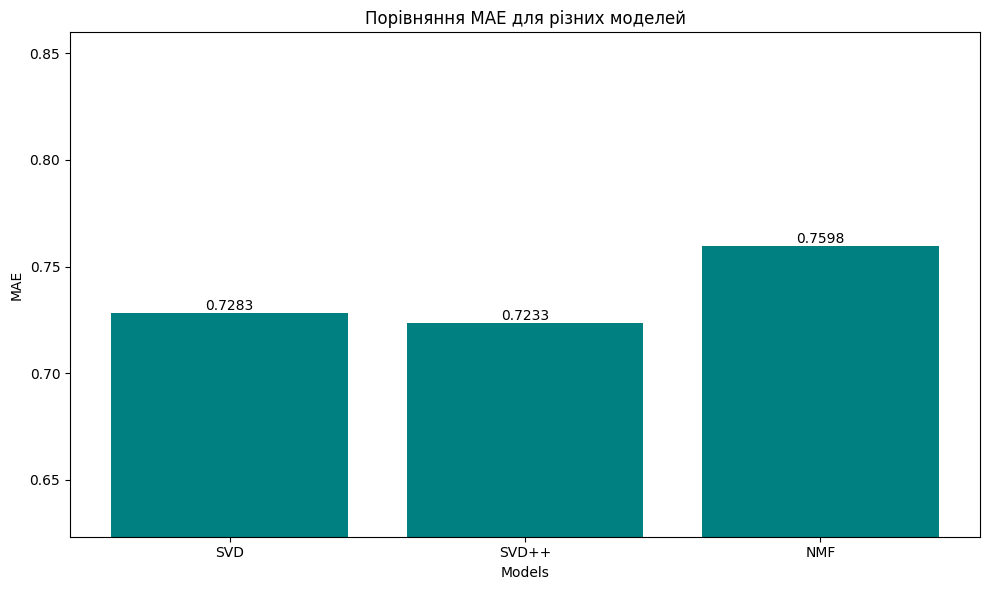

In [485]:
plt.figure(figsize=(10, 6))
plt.title("Порівняння MAE для різних моделей")
plt.ylabel("MAE")
plt.xlabel("Models")
plt.ylim(min(df_results["MAE"]) - 0.1, max(df_results["MAE"]) + 0.1)
plt.xticks(rotation=0)
bars = plt.bar(df_results["Method"], df_results["MAE"], color="teal")
plt.tight_layout()

for bar in bars:
    val = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        val,
        round(val, 4),
        va="bottom",
        ha="center",
    )

plt.show()

<div class="alert alert-block alert-info">
<b>Висновки:</b> 
<p>Можна побачити, що методи SVD і SVD++ показали кращі результати, ніж метод NMF.
<br>SVD++ показав найкращий результат, але йому потрібно набагато більше (в 20 разів!!!) часу для навчання моделі та отримання необхідних даних.
</div>